# Setting up

In [124]:
import pickle 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import re
import seaborn as sns

In [125]:
# tools which use the dinucleotide positional features 
tools_of_interest = ['ssc' ,'sgrnascorer2','tuscan-classification' ,'tuscan-regression','chop-chop-doench','chop-chop-xu', 'wu-crispr', 'deep-crispr']
dataset_name = 'xu'

# features of interest (to be highlighted)
features_of_interest = ['19:G', '19:C', '19:T', '17:C', '18:T', '17:T', '15:C', '13:T', '11:A', '2:G']

## Helpers to determine sequential features

In [126]:
# from a list of features, return those which are sequential features 
def getSequentials(feature_names):
    sequentials = []
    for f in feature_names: 
        if isSequential(f):
            sequentials.append(f)
    return sequentials

In [127]:
# given a feature name, matches the content and returns the match (None if not sequential feature)
def isSequential(feature_name):
    
    # NP or N:P
    m = re.match(r"^(?P<nuc>[ACGT])(:)?(?P<pos>([0-9])*)$", feature_name)
    
    if m == None: # try PN or P:N 
        m = re.match(r"^(?P<pos>([0-9])*)(:)?(?P<nuc>[ACGT])$", feature_name)
                     
    if m == None: # try c1_P:N_sd
        m = re.match(r"^c1_(?P<pos>([0-9])*)(:)?(?P<nuc>[ACGT])_sd$", feature_name)
    
    return m

In [128]:
def getAllVersions(feature_name):
    match = isSequential(feature_name) 
    
    options = []
    options.append( match['pos'] + ":" + match['nuc'] ) 
    options.append( match['pos'] + match['nuc'] )
    options.append( match['nuc'] + ":" + match['pos'] )
    options.append( match['nuc'] + match['pos'] )
    options.append( "c1_" + match['pos'] + ":" + match['nuc'] + "_sd" )
    
    return options
    
    

In [129]:
getAllVersions("17:C")

['17:C', '17C', 'C:17', 'C17', 'c1_17:C_sd']

In [130]:
def findIn(feature_name, features):
    options = getAllVersions(feature_name)
    
    for o in options: 
        if o in features: 
            return o
    return None

## Helpers to load and scale data 

At the end of the loading we will have a dataframe which contains positional features only and in which all values are scaled considering the absolute value

In [131]:
def scale_by_tool(tool_df):
    vals = tool_df.values.flatten()

    max_val = max(vals)
    min_val = min(vals)
    
    # maximum by absolute value in the list (all shap values for positional dinucleotide features)
    max_abs = abs(min_val)
    if abs(max_val) > abs(min_val):
        max_abs = abs(max_val) 
        
    # divide by the max_abs in the list
   
    new_tool_df = tool_df.divide(max_abs)
    
    return new_tool_df
    

In [132]:
# loads the shapValues and dataset but only keeps sequential features !!
# !! includes scaling the values to only sequentials
def loadPickle(tool_name):
    # load data from pickle
    pickleFileName = "SHAP-" + tool_name + "-" + dataset_name
    p = open('./pickles/'+pickleFileName,"rb")
    shapValues = pickle.load(p)
    dataset = pickle.load(p)
    p.close()

    shapValues = pd.DataFrame(shapValues, columns=dataset.columns)
    
    # keep only sequential features 
    seqFeatures = getSequentials(dataset.columns)
    shapValues = shapValues[seqFeatures]
    dataset = dataset[seqFeatures]
    
    # scale sequential values 
    shapValues = scale_by_tool(shapValues)
    
    return shapValues, dataset

# Load all tools data 

In [133]:
tool_feature_to_vals = {}
for tool in tools_of_interest: 
    sh, d = loadPickle(tool)
    tool_feature_to_vals[tool] = {}
    for f in features_of_interest: 
        f_name = findIn(f, sh.columns)
        if f_name == None: 
            continue
  
        f_sh = sh[[f_name]]
        f_sh = f_sh.loc[d[f_name] == 1]

        # f_sh contains all the shap values for 1-valued data points of feature f 
        tool_feature_to_vals[tool][f] = f_sh.values
        

The tool_feature_to_vals dictionary has for each tool and important feature all the relevant shap values

In [134]:
tool_feature_to_vals['ssc']['19:G']

array([[0.76976993],
       [0.76976993],
       [0.76976701],
       [0.77022219],
       [0.76976993],
       [0.77015879],
       [0.76976993],
       [0.76976993],
       [0.76978231],
       [0.76997838],
       [0.76976993],
       [0.77033392],
       [0.77006354],
       [0.77013989],
       [0.76976993],
       [0.77013967],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76836094],
       [0.76993606],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.77004412],
       [0.76993446],
       [0.76976993],
       [0.77031538],
       [0.76976993],
       [0.76976993],
       [0.76976993],
       [0.769

# Plot 

In [135]:
def plotForFeature(feature):
    
    plt.plot([0] * len(tools_of_interest), color= "grey", linewidth="0.5")
    
    data = []
    datas = []
    for i, tool in enumerate(tools_of_interest): 
        if feature not in tool_feature_to_vals[tool].keys(): 
            datas.append([0])
            continue
        vals = tool_feature_to_vals[tool][feature] 
        #plt.scatter([i] * len(vals), vals)
        #plt.violinplot(vals)
        
        dd = []
        for v in vals: 
            dd.append(v[0])
        datas.append(dd)
        
    plt.violinplot(datas, positions=np.arange(0,len(tools_of_interest)))
    plt.yticks(np.arange(-1,1.25,0.25))
    plt.xticks(np.arange(0,len(tools_of_interest)), tools_of_interest, rotation='vertical')
    plt.ylabel("SHAP value")
    plt.title("SHAP values for "+ feature)

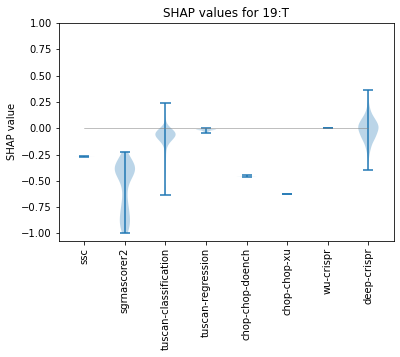

In [136]:
plotForFeature("19:T")

## Plot with sns

In [207]:
def plotSNSForFeature(feature):
    
    data = []
    datas = []
    rows = []
    for i, tool in enumerate(tools_of_interest): 
        if feature not in tool_feature_to_vals[tool].keys(): 
            datas.append([0])
            continue
        vals = tool_feature_to_vals[tool][feature] 
        
        dd = []
        for v in vals: 
            dd.append(v[0])
            rows.append( [i,v[0]] )
       
        # dd are the values for tool #i 
      
    
    df = pd.DataFrame(rows, columns=['Tool','Shap'])
    ax = sns.violinplot(x=df["Tool"], y=df['Shap'],  data = pd.melt(df), width=0.75, scale='width')
    base = np.arange(-1,len(tools_of_interest)+1) 
    ax.plot(base,[0]*len(base), linewidth=0.5, color='grey')
    ax.set(ylim=(-1.1, 1.1))
    
    #ax.set(xticks=np.arange(0,len(tools_of_interest)))
    #ax.set_xticklabels(tools_of_interest, rotation=90)
    ax.set_title("SHAP values for " + feature)
    ax.set(xticks=[])
    ax.set(xlabel='')
    
    

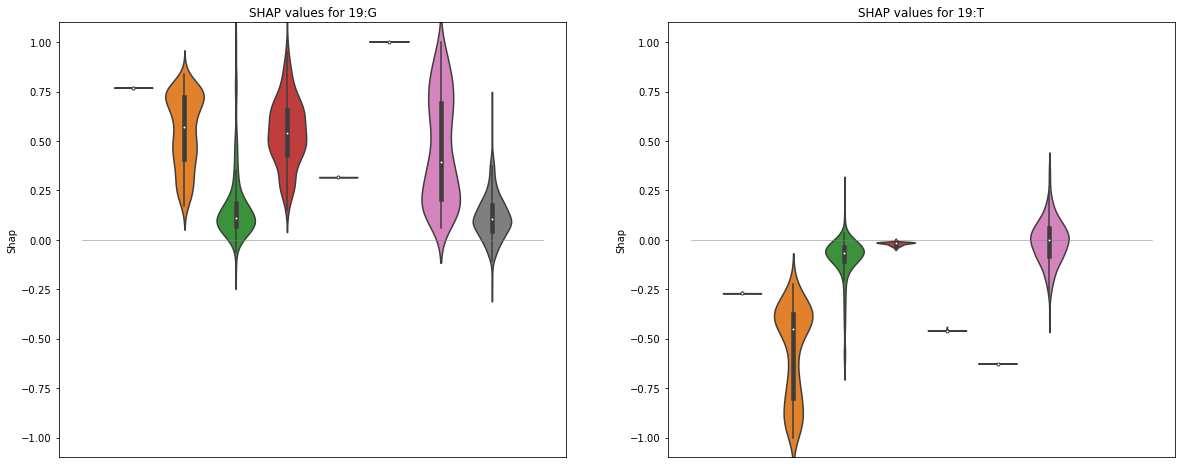

In [218]:
fig = plt.figure(figsize=(20,8))


ax1 = plt.subplot(121)
plotSNSForFeature("19:G")

ax2 = plt.subplot(122)
plotSNSForFeature("19:T")